# 개요

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve
from scipy import sparse
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [78]:
# 데이터 가져오기 
data_path = '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.3/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv') 
origin = pd.read_csv(data_path + 'WA_Fn-UseC_-HR-Employee-Attrition.csv')

origin.shape, train.shape, test.shape, submission.shape

# 훈련용 데이터가 피처 수에 비해 너무 적음 => 과적합이 일어날 수 있다

((1470, 35), (1677, 35), (1119, 34), (1119, 2))

In [79]:
# origin, train, test, submission 열 확인
origin.columns, train.columns, test.columns, submission.columns

(Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
        'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
        'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
        'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
        'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
        'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
        'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
        'YearsWithCurrManager'],
       dtype='object'),
 Index(['id', 'Age', 'BusinessTravel', 'DailyRate', 'Department',
        'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
        'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
        'JobLevel', 'JobRole', 'JobSatisfaction', 'Marital

- < 각 열에 대한 정보 확인 >

|컬럼명|내용|해석|
|------|---|---|
|id|고유 ID|확인 결과 id 컬럼은 인덱스와 같은 의미(제거 가능)
Age|나이|수치형
Attrition|타겟변수, 정답 값|0, 1 => 이진형
BusinessTravel|출장|Travel_Frequently, Travel_Rarely, Non-Travel => 범주형
DailyRate|급여 수준|수치형
Department|부서|Research & Development, Sales, Human Resources => 범주형
DistanceFromHome'|집에서 직장까지의 거리|수치형
Education|교육|수치형
EducationField|교육분야|Medical, Other, Marketing, Life Sciences, Technical Degree, Human Resources => 범주형
EmployeeCount|직원 수|수치형
EmployeeNumber|직원 id|수치형
EnvironmentSatisfaction|환경에 대한 만족도|[2, 3, 4, 1] => 범주형(순서형)
Gender|성별|Female, Male => 범주형(이진형)
HourlyRate|시간당 급여|수치형
JobInvolvement|직무관련성|[3, 2, 4, 1] => 범주형(순서형?), 수치형?
JobLevel|작업 수준|[2, 1, 3, 4, 5] => 범주형(순서형?), 수치형?
JobRole|직무 역할|Sales Executive, Research Scientist, Laboratory Technician, Manufacturing Director, Healthcare Representative, Manager, Sales Representative, Research Director, Human Resources => 범주형
JobSatisfaction|직무 만족도|[4, 2, 3, 1] => 범주형(순서형)
MaritalStatus|결혼 여부|Single, Married, Divorced => 범주형
MonthlyIncome|월 급여|수치형
MonthlyRate|월 요율|수치형
NumCompaniesWorked|일한 회사 수|수치형
Over18|18세 이상|Y만 있음, 이진형으로 볼 수 있나?
OverTime|초과 근무|Yes, No => 이진형
PercentSalaryHike|급여 인상률|수치형
PerformanceRating|성능(활약)등급?|3, 4 => 이진형
RelationshipSatisfaction|관계 만족도|2, 4, 3, 1 => 범주형(순서형)?, 수치형?
StandardHours|표준 시간|80만 있음 => 뭐로봐야하지?
StockOptionLevel|스톡옵션수준|0, 1, 3, 2 => 범주형(순서형)?, 수치형?
TotalWorkingYears|총 근무 연수|수치형
TrainingTimesLastYear|작년 교육 시간|수치형
WorkLifeBalance|워라벨|1, 3, 2, 4 => 범주형(순서형)?, 수치형?
YearsAtCompany|회사에서의 총 근무 연수|수치형
YearsInCurrentRole|현재 역할 근무 연수|수치형
YearsSinceLastPromotion|마지막 프로모션|수치형
YearsWithCurrManager|현재 관리자 연수|수치형


In [80]:
train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1677 non-null   int64 
 1   Age                       1677 non-null   int64 
 2   BusinessTravel            1677 non-null   object
 3   DailyRate                 1677 non-null   int64 
 4   Department                1677 non-null   object
 5   DistanceFromHome          1677 non-null   int64 
 6   Education                 1677 non-null   int64 
 7   EducationField            1677 non-null   object
 8   EmployeeCount             1677 non-null   int64 
 9   EnvironmentSatisfaction   1677 non-null   int64 
 10  Gender                    1677 non-null   object
 11  HourlyRate                1677 non-null   int64 
 12  JobInvolvement            1677 non-null   int64 
 13  JobLevel                  1677 non-null   int64 
 14  JobRole                 

In [82]:
test.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1677,19,Non-Travel,992,Research & Development,1,1,Medical,1,4,...,4,80,0,1,2,2,1,0,0,0
1,1678,45,Travel_Rarely,1136,Sales,4,4,Marketing,1,3,...,3,80,1,7,3,3,2,2,2,2
2,1679,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,1,4,...,2,80,2,13,2,2,7,7,1,7
3,1680,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,1,3,...,3,80,0,14,2,2,14,10,11,8
4,1681,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,1,3,...,1,80,0,1,5,3,1,0,0,0


In [83]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1119 non-null   int64 
 1   Age                       1119 non-null   int64 
 2   BusinessTravel            1119 non-null   object
 3   DailyRate                 1119 non-null   int64 
 4   Department                1119 non-null   object
 5   DistanceFromHome          1119 non-null   int64 
 6   Education                 1119 non-null   int64 
 7   EducationField            1119 non-null   object
 8   EmployeeCount             1119 non-null   int64 
 9   EnvironmentSatisfaction   1119 non-null   int64 
 10  Gender                    1119 non-null   object
 11  HourlyRate                1119 non-null   int64 
 12  JobInvolvement            1119 non-null   int64 
 13  JobLevel                  1119 non-null   int64 
 14  JobRole                 

In [84]:
origin.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [85]:
origin.info() 
# Attrition 데이터가 문자형으로 되어있다 => 확인 후 수치형으로 변환

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [86]:
origin['Attrition'].unique()

array(['Yes', 'No'], dtype=object)

In [87]:
# origin
origin['Attrition'] = origin['Attrition'].map({
    'No': 0,
    'Yes': 1,
}).astype('int')

In [88]:
submission

,id,Attrition
0,1677,0.119261
1,1678,0.119261
2,1679,0.119261
3,1680,0.119261
4,1681,0.119261
...,...,...
1114,2791,0.119261
1115,2792,0.119261
1116,2793,0.119261
1117,2794,0.119261


# 초기 파악

## 결측치 확인

In [89]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 비율로 확인
def null_per(df):
    return (df.isnull().sum() / len(df)*100).sort_values(ascending=False)

plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Original Dataset", "Training Dataset","Test Dataset"))

null_per_origin = null_per(origin)
null_per_train = null_per(train)
null_per_test = null_per(test)

print(null_per_origin)
fig.add_trace(
    go.Bar(x=null_per_origin.index, y=null_per_origin.values),
    row=1, col=1
)

print(null_per_train)

fig.add_trace(
    go.Bar(x=null_per_train.index, y=null_per_train.values),
    row=1, col=2
)

print(null_per_test)

fig.add_trace(
    go.Bar(x=null_per_test.index, y=null_per_test.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 결측치 없음

Age                         0.0
StandardHours               0.0
NumCompaniesWorked          0.0
Over18                      0.0
OverTime                    0.0
PercentSalaryHike           0.0
PerformanceRating           0.0
RelationshipSatisfaction    0.0
StockOptionLevel            0.0
MonthlyIncome               0.0
TotalWorkingYears           0.0
TrainingTimesLastYear       0.0
WorkLifeBalance             0.0
YearsAtCompany              0.0
YearsInCurrentRole          0.0
YearsSinceLastPromotion     0.0
MonthlyRate                 0.0
MaritalStatus               0.0
Attrition                   0.0
EmployeeCount               0.0
BusinessTravel              0.0
DailyRate                   0.0
Department                  0.0
DistanceFromHome            0.0
Education                   0.0
EducationField              0.0
EmployeeNumber              0.0
JobSatisfaction             0.0
EnvironmentSatisfaction     0.0
Gender                      0.0
HourlyRate                  0.0
JobInvol

<Figure size 432x288 with 0 Axes>

## 고유값 확인

In [90]:
plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Unique values For Original Dataset", "For Training Dataset","For Test Dataset"))

temp_data= origin.nunique().sort_values()
print(temp_data)
fig.add_trace(
    go.Bar(x=temp_data.index, y=temp_data.values),
    row=1, col=1
)

temp2_data= train.nunique().sort_values()
print(temp2_data)

fig.add_trace(
    go.Bar(x=temp2_data.index, y=temp2_data.values),
    row=1, col=2
)

temp3_data= test.nunique().sort_values()
print(temp3_data)

fig.add_trace(
    go.Bar(x=temp3_data.index, y=temp3_data.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 고유값 1개 : Over18, StandardHours, EmployeeCount => 굳이 필요할까?
# 이진형 : Gender, Attrition, PerformanceRating, OverTime 
# 범주형 : MaritalStatus, Department, BusinessTravel, ...                                                      
# 수치형 : ... 

Over18                         1
StandardHours                  1
EmployeeCount                  1
Gender                         2
Attrition                      2
PerformanceRating              2
OverTime                       2
MaritalStatus                  3
Department                     3
BusinessTravel                 3
StockOptionLevel               4
EnvironmentSatisfaction        4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
WorkLifeBalance                4
Education                      5
JobLevel                       5
EducationField                 6
TrainingTimesLastYear          7
JobRole                        9
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate

<Figure size 432x288 with 0 Axes>

## 중복값 확인

In [91]:
train.shape, train.drop_duplicates().shape

((1677, 35), (1677, 35))

In [92]:
test.shape, test.drop_duplicates().shape

((1119, 34), (1119, 34))

In [93]:
origin.shape, origin.drop_duplicates().shape

((1470, 35), (1470, 35))

## 전체 요약

In [94]:
def summary(df):
    print(f'data shape: {df.shape}')
    sum_df = pd.DataFrame(df.dtypes, columns=['type'])
    sum_df['null'] = df.isnull().sum().values * 100
    #sum_df['missing_per'] = df.isnull().sum().values / len(df)
    sum_df['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    sum_df['min'] = desc['min'].values
    sum_df['max'] = desc['max'].values
    sum_df['mean'] = desc['mean'].values
    sum_df['first value'] = df.iloc[0].values
    sum_df['second value'] = df.iloc[1].values
    sum_df['third value'] = df.iloc[2].values
    
    return sum_df
    
summary_df = summary(train)
summary_df

data shape: (1677, 35)


,type,null,unique,min,max,mean,first value,second value,third value
id,int64,0,1677,0.0,1676.0,838.0,0,1,2
Age,int64,0,43,18.0,60.0,36.036971,36,35,32
BusinessTravel,object,0,3,NaN,NaN,NaN,Travel_Frequently,Travel_Rarely,Travel_Rarely
DailyRate,int64,0,625,107.0,3921.0,892.749553,599,921,718
Department,object,0,3,NaN,NaN,NaN,Research & Development,Sales,Sales
DistanceFromHome,int64,0,29,1.0,29.0,8.683959,24,8,26
Education,int64,0,6,1.0,15.0,2.937984,3,3,3
EducationField,object,0,6,NaN,NaN,NaN,Medical,Other,Marketing
EmployeeCount,int64,0,1,1.0,1.0,1.0,1,1,1
EnvironmentSatisfaction,int64,0,4,1.0,4.0,2.757901,4,1,3


# EDA

## Target 분포 확인

타겟값간 비율 7.384999999999999


Text(0.5, 1.0, 'Attrition Value Distribution')

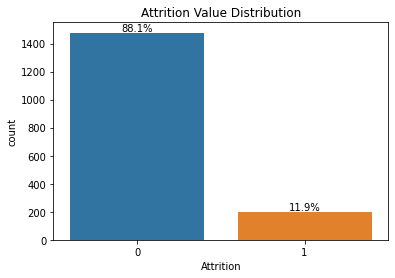

In [95]:
# 향후 시각화 자료에 비율을 표기하는 부분을 추가 => 텍스트 드로잉
def show_text_percent_by_Attrition( ax, total_count, is_show=True,  ):
  '''
    is_show : True일대만 텍스트가 노출되게 처리
    ax : 텍스트를 그리고자 하는 차트의 축정보
    total_count : 전체 카운트수
  '''
  persents = list()         # 비율을 담는 그릇
  # 카운트 플롯 차트상에 개별 박스 정보를 구하는 방법 -> ax.patches

  # 카운트 플롯 차트상에서 순차적으로 박스를 하나식 추출한다
  for patch in ax.patches: # 차트상에 존재하는 모든 형태의 도형을 차례대로 추출하는 연속형 변수
    w = patch.get_width()  # 타겟값 0 혹은 1, 카운트 플롯의 개별 박스 너비
    h = patch.get_height() # 타겟값 0 혹은 1의 카운트수 -> 카운트 플롯의 개별 박스 높이->카운트
    p = h/total_count * 100 # 타깃값의 비율 = (개별박스의 높이(카운트) / 전체카운트)*100
    persents.append( p )
    # 텍스트 그리기
    # 좌표 정보 획득
    l = patch.get_x()    # 도형 왼쪽 테투리 X축의 기준 위치값    
    ax.text(  x=l + w/2,  # 도형의 정 가운데를 X축 좌표
              y=h + total_count*0.005, # 1, total_count(가변값)의 특정 비율로 올려서 위치를 조정
              s=f'{p:1.1f}%', # 타겟값의 비율을 개별 차트내 도형 위에 그려지는 내용 ex) 38.8%
              ha='center'    # 정렬(가운데)
            )
  if is_show:
    if len(persents) == 2:   # 타겟용
      print( '타겟값간 비율', persents[0]/persents[1] )
    elif len(persents) == 4: # 이진 피처용
      # print( persents )
      # 타겟값에 맞춰서 도형이 그려진다 0번 타겟이 먼저 그려지고, 1번 타겟이 나중에 그려진다
      print( persents[0]/persents[2], persents[1]/persents[3] )
  pass

ax = sns.countplot( data=train, x='Attrition');
show_text_percent_by_Attrition( ax, train.shape[0] )
ax.set_title('Attrition Value Distribution')
# 퇴사를 하지 않은 사람이 한 사람보다 7.384999999999999배 많음

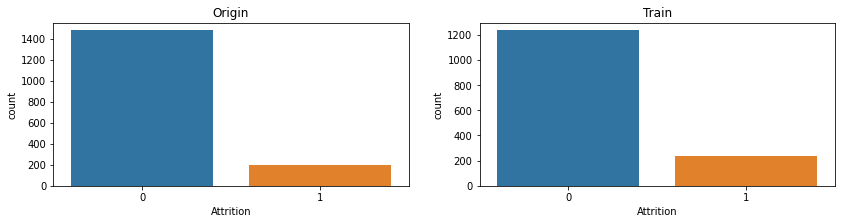

In [96]:
plt.figure(figsize=(14,3))
ax1 = plt.subplot(1,2,1)
sns.countplot(data=train, x='Attrition');
plt.title('Origin')
ax2 = plt.subplot(1,2,2)
sns.countplot(data=origin, x='Attrition');
plt.title('Train')
plt.show()
# 퇴사한 사람보다 퇴사 안 한 사람이 훨씬 많음 -> 데이터 불균형함 -> train/test 시 startify = y 설정 또는 startify-fold로 모델 평가 진행

## 피처 요약 기준 해석 및 전략 수립

- 고유값이 1개라서 필요없다고 생각되는 피처 : ["EmployeeCount", "Over18", "StandardHours"]
- 수치형 : ["Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyIncome", "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear","YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion" ,"YearsWithCurrManager"]
- 범주형 : ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'] 


In [97]:
# 수치형, 범주형 분류

# 고유값이 1개인 피처
one_cols = ["EmployeeCount", "Over18", "StandardHours"]
# 수치형
num_cols =  ["Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyIncome", "MonthlyRate", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", "TrainingTimesLastYear","YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion" ,"YearsWithCurrManager"]

# 범주형
cat_cols = ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
cat_cols_v1 = ['Gender', 'OverTime', 'PerformanceRating']
cat_cols_v2 = ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
# 범주형을 고유값 개수에 따라 세부 분류함
# 이진형 데이터 - Attrition, Gender, OverTime, PerformanceRating

### 고유값이 1개인 피처들

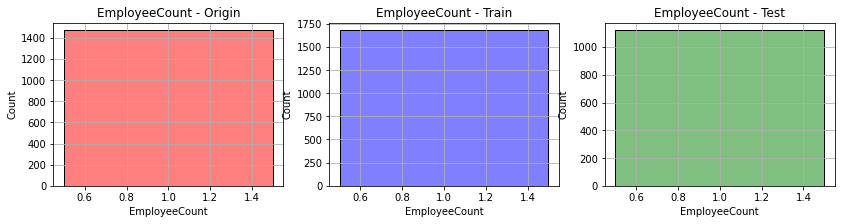

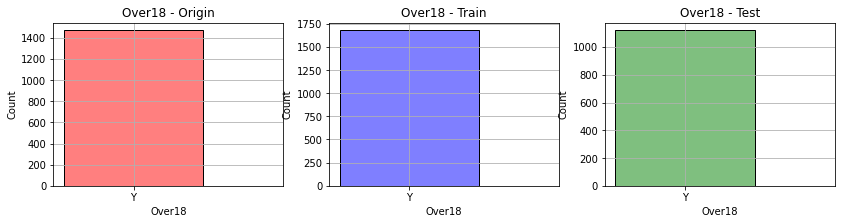

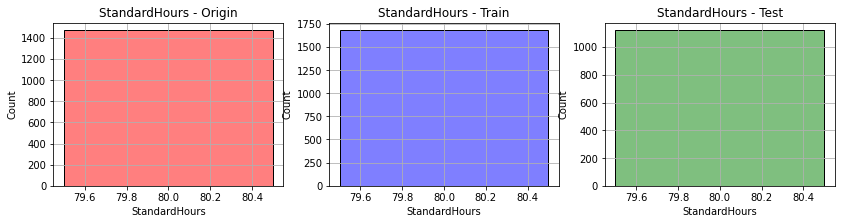

In [98]:
for one_col in one_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.histplot(x=origin[one_col], color='r', kde=True)
  plt.title(one_col + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.histplot(x=train[one_col], color='b', kde=True)
  plt.title(one_col + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.histplot(x=test[one_col],color='g', kde=True)
  plt.title(one_col + ' - Test')
  plt.grid()
  plt.show()

# 제거하는게 좋아보임

### 수치형 

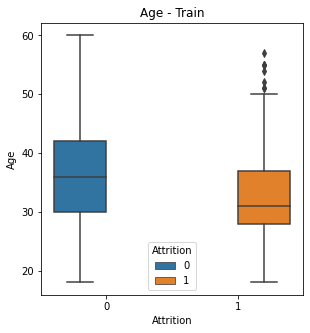

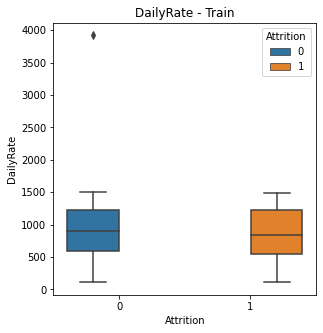

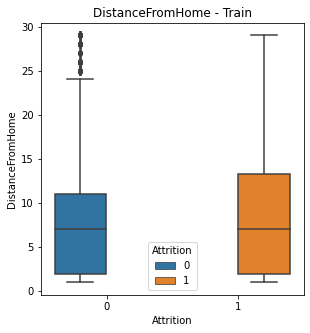

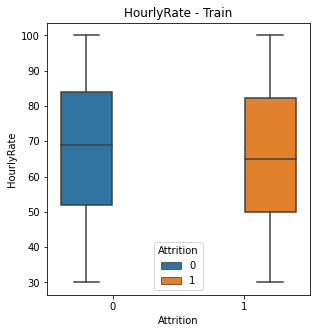

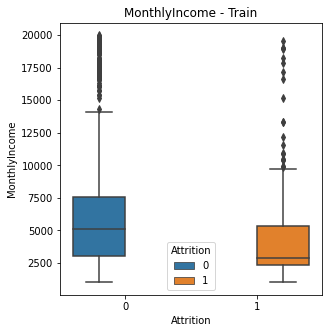

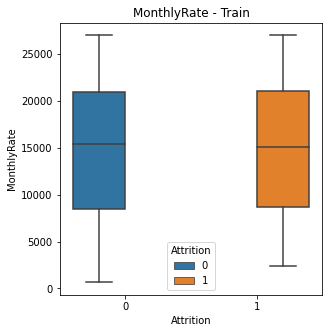

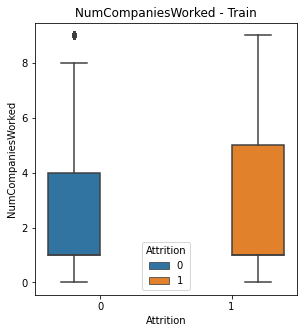

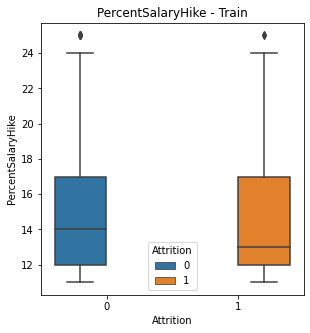

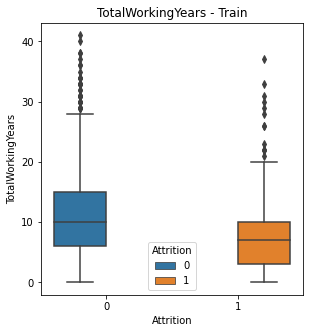

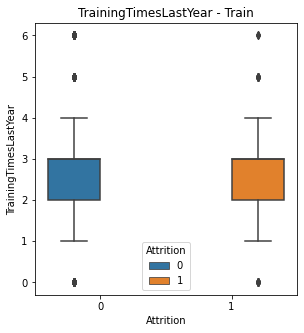

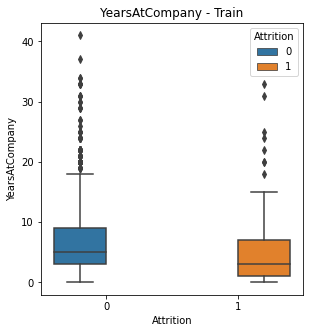

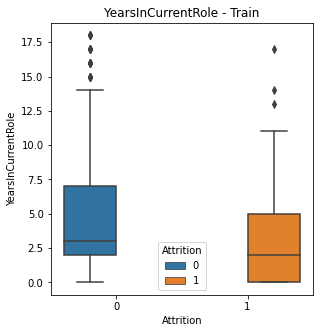

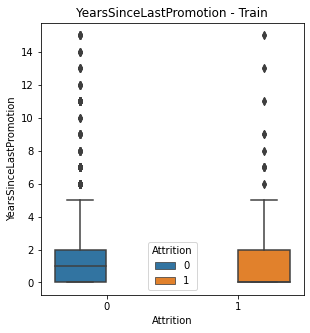

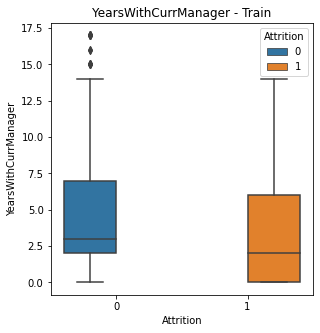

In [99]:
# 수치형 
for num_col in num_cols:
  plt.figure(figsize=(16, 5))
  ax_box = plt.subplot(1,3,1)
  sns.boxplot(x = 'Attrition', y=train[num_col], hue = 'Attrition', data=train)
  plt.title(num_col + ' - Train')
  plt.grid

# DailyRate, DistanceFromHome, HourlyRate, MonthlyRate, NumCompaniesWorked, PercentSalaryHike, TrainingTimesLastYear, YearsSinceLastPromotion => 분포가 비슷하여 삭제해도 될듯

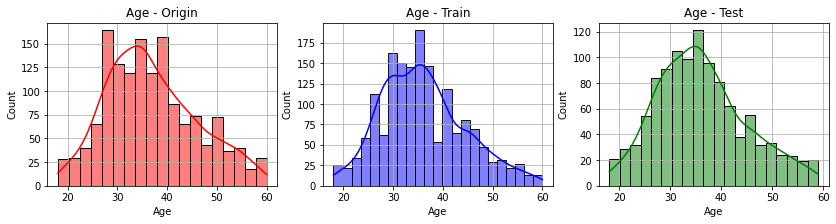

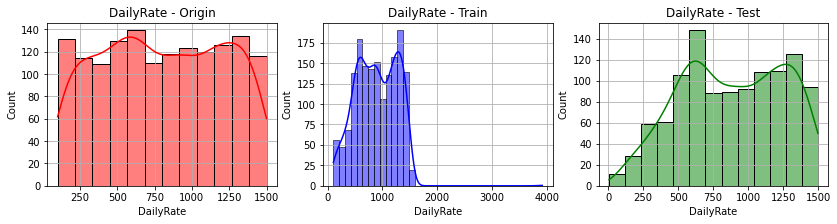

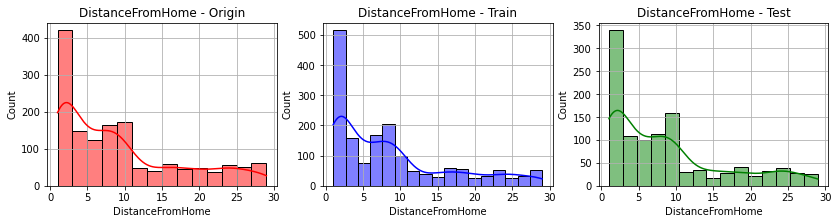

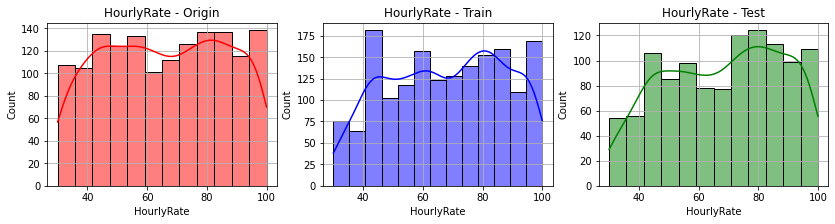

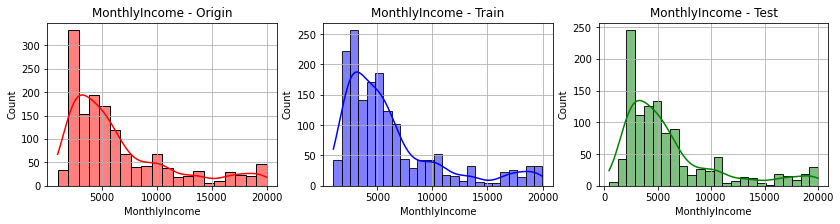

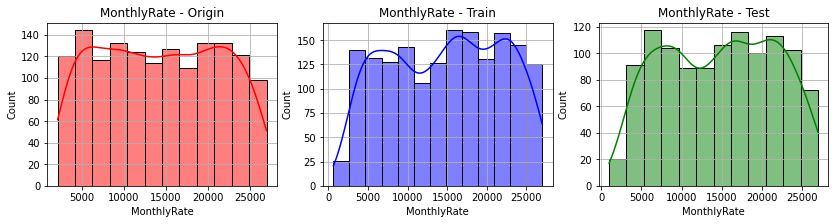

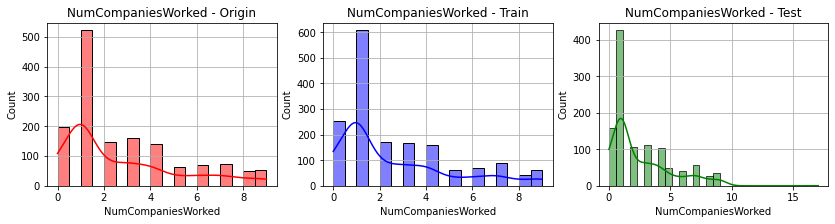

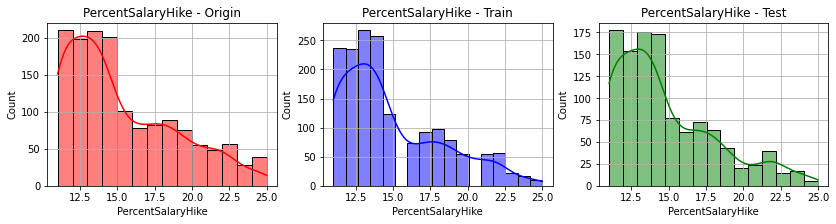

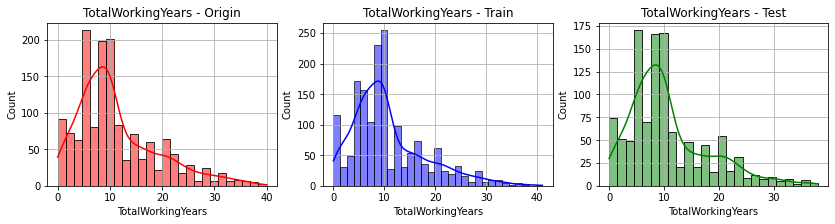

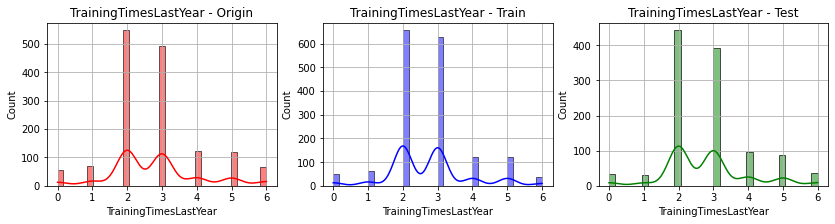

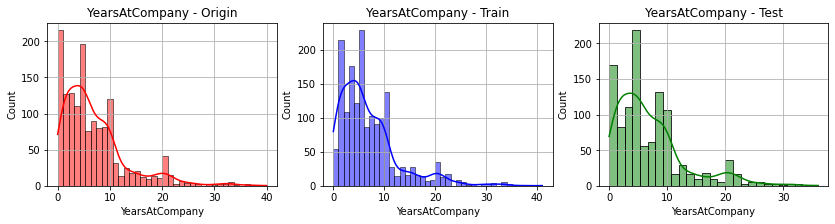

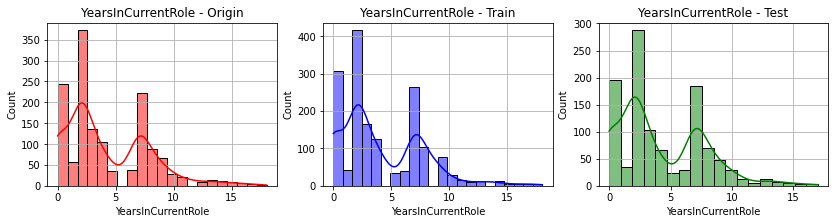

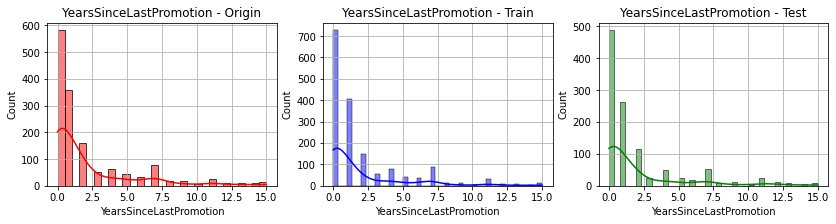

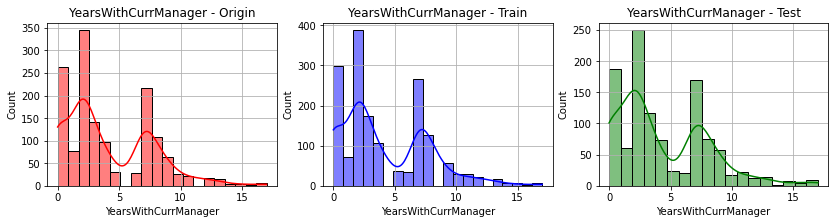

In [100]:
for num_col in num_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.histplot(x=origin[num_col], color='r', kde=True)
  plt.title(num_col + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.histplot(x=train[num_col], color='b', kde=True)
  plt.title(num_col + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.histplot(x=test[num_col],color='g', kde=True)
  plt.title(num_col + ' - Test')
  plt.grid()
  plt.show()

### 범주형(이진형)

6.710144927536232 8.887096774193548


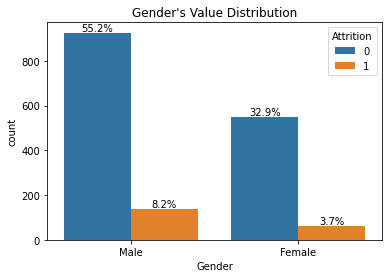

3.545454545454546 10.401785714285714


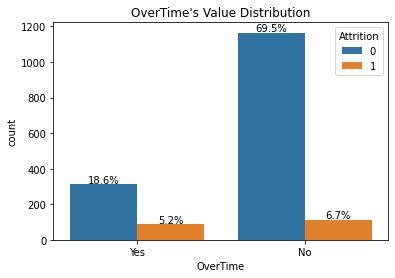

7.5058139534883725 6.642857142857143


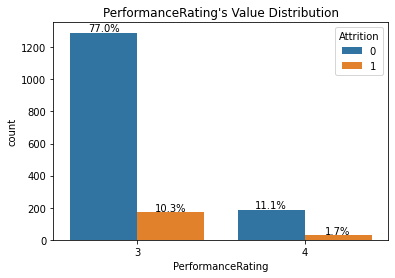

In [101]:
# 이진형 데이터별 
for cat_col_v1 in cat_cols_v1:
  ax = sns.countplot( data=train, x=cat_col_v1, hue='Attrition');
  show_text_percent_by_Attrition( ax, train.shape[0] )
  ax.set_title(f'{cat_col_v1}\'s Value Distribution')
  plt.show();
  
# 성별 : 남성이 여성보다 더 많이 퇴사 
# 추가근무 : 추가근무를 하지 않는 사람의 비율이 더 높으며 안 한 사람이 퇴사를 더 많이함
# performance rating : 3인 사람이 4인 사람보다 더 많으며 퇴사 비율도 더 높다

In [102]:
# 이진형 데이터
# for cat_col_v1 in cat_cols_v1:
#  plt.figure(figsize=(16, 5))
#  ax_box = plt.subplot(1,3,1)
#  sns.boxplot(x = 'Attrition', y=train[cat_col_v1], hue = 'Attrition', data=train)
#  plt.title(cat_col_v1 + ' - Train')
#  plt.grid

- PerformanceRating 삭제

### 범주형(고유값 3개 이상)

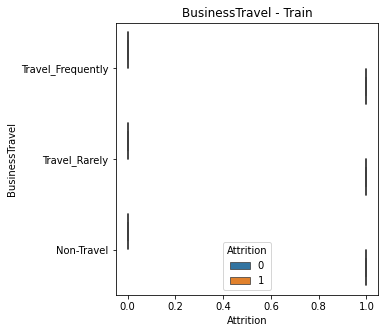

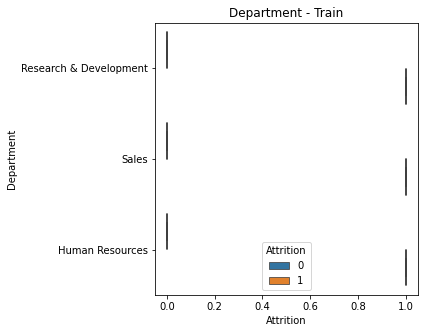

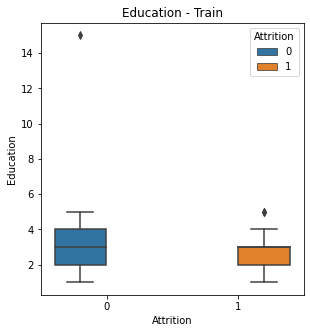

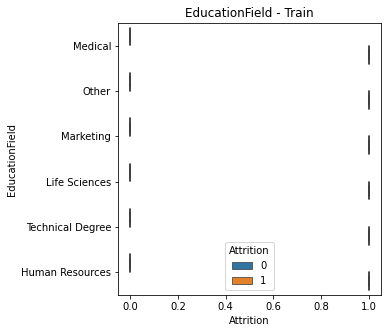

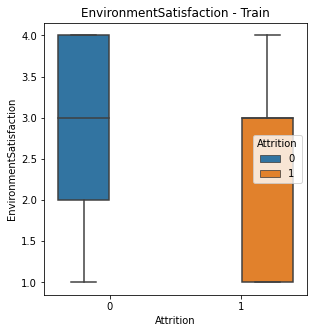

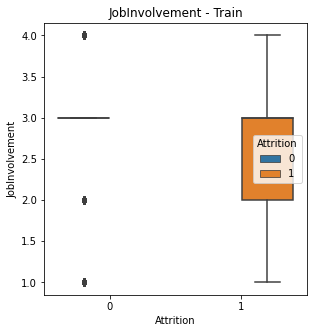

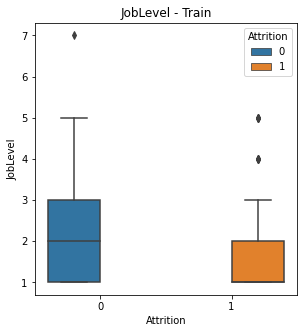

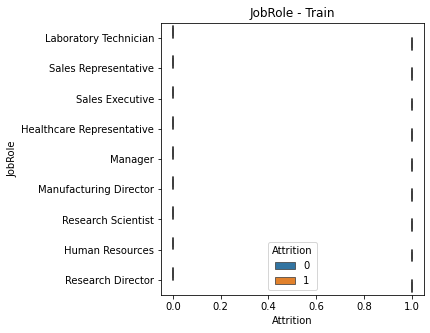

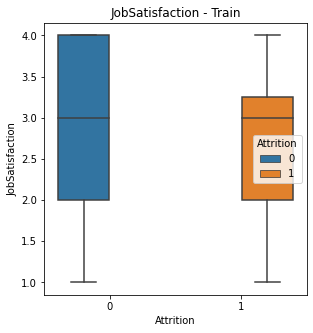

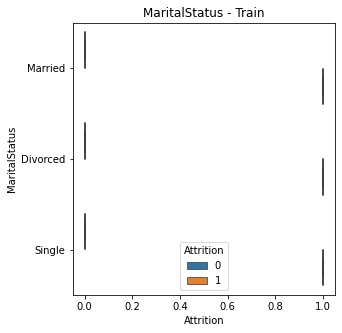

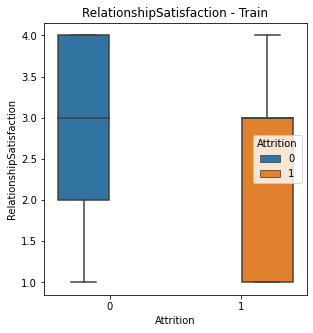

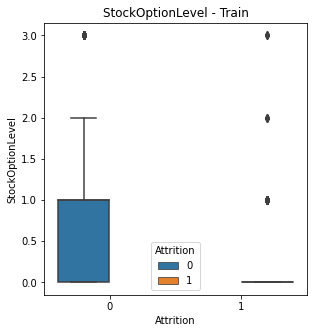

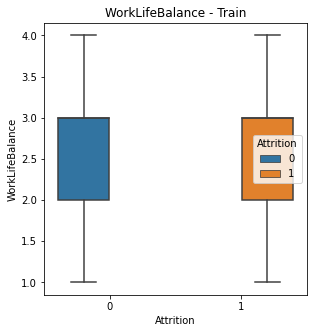

In [103]:
for cat_col_v2 in cat_cols_v2:
  plt.figure(figsize=(16, 5))
  ax_box = plt.subplot(1,3,1)
  sns.boxplot(x = 'Attrition', y = train[cat_col_v2], hue = 'Attrition', data=train)
  plt.title(cat_col_v2 + ' - Train')
  plt.grid

  # Education, JobLevel, JobSatisfaction, StockOptionLevel, WorkLifeBalance

# 데이터 병합

In [104]:
train = pd.concat( [train, origin] )  
train.shape

(3147, 36)

## 피처 엔지니어링

### 피처 삭제

In [105]:
train = train.drop(columns = ['id', "EmployeeCount", "Over18", "StandardHours", 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyRate', 'NumCompaniesWorked', 
                              'PercentSalaryHike', 'TrainingTimesLastYear', 'YearsSinceLastPromotion','PerformanceRating', 
                              'Education', 'JobLevel', 'JobSatisfaction', 'StockOptionLevel', 'WorkLifeBalance', 'EmployeeNumber'])
test = test.drop(columns = ['id', "EmployeeCount", "Over18", "StandardHours", 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyRate', 'NumCompaniesWorked', 
                              'PercentSalaryHike', 'TrainingTimesLastYear', 'YearsSinceLastPromotion','PerformanceRating', 
                              'Education', 'JobLevel', 'JobSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'])

"EmployeeCount", "Over18", "StandardHours"

('EmployeeCount', 'Over18', 'StandardHours')

In [106]:
train.shape, test.shape
# 하나가 더 많은 이유 -> 오리지날 데이터에서 EmployeeNumber 컬럼이 합쳐졌다
# -> 확인해보니 큰 의미 없을 것 같음 => 삭제

((3147, 17), (1119, 16))

In [107]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3147 entries, 0 to 1469
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       3147 non-null   int64 
 1   BusinessTravel            3147 non-null   object
 2   Department                3147 non-null   object
 3   EducationField            3147 non-null   object
 4   EnvironmentSatisfaction   3147 non-null   int64 
 5   Gender                    3147 non-null   object
 6   JobInvolvement            3147 non-null   int64 
 7   JobRole                   3147 non-null   object
 8   MaritalStatus             3147 non-null   object
 9   MonthlyIncome             3147 non-null   int64 
 10  OverTime                  3147 non-null   object
 11  RelationshipSatisfaction  3147 non-null   int64 
 12  TotalWorkingYears         3147 non-null   int64 
 13  YearsAtCompany            3147 non-null   int64 
 14  YearsInCurrentRole      

In [108]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1119 non-null   int64 
 1   BusinessTravel            1119 non-null   object
 2   Department                1119 non-null   object
 3   EducationField            1119 non-null   object
 4   EnvironmentSatisfaction   1119 non-null   int64 
 5   Gender                    1119 non-null   object
 6   JobInvolvement            1119 non-null   int64 
 7   JobRole                   1119 non-null   object
 8   MaritalStatus             1119 non-null   object
 9   MonthlyIncome             1119 non-null   int64 
 10  OverTime                  1119 non-null   object
 11  RelationshipSatisfaction  1119 non-null   int64 
 12  TotalWorkingYears         1119 non-null   int64 
 13  YearsAtCompany            1119 non-null   int64 
 14  YearsInCurrentRole      

### object => 수치형으로 변환 필요

In [109]:
train['BusinessTravel'].unique() 
# 순서형

array(['Travel_Frequently', 'Travel_Rarely', 'Non-Travel'], dtype=object)

In [110]:
train['Department'].unique()
# 범주형

array(['Research & Development', 'Sales', 'Human Resources'], dtype=object)

In [111]:
train['EducationField'].unique()
# 범주형

array(['Medical', 'Other', 'Marketing', 'Life Sciences',
       'Technical Degree', 'Human Resources'], dtype=object)

In [112]:
train['Gender'].unique()
# 범주형

array(['Male', 'Female'], dtype=object)

In [113]:
train['JobRole'].unique()
# 범주형

array(['Laboratory Technician', 'Sales Representative', 'Sales Executive',
       'Healthcare Representative', 'Manager', 'Manufacturing Director',
       'Research Scientist', 'Human Resources', 'Research Director'],
      dtype=object)

In [114]:
train['MaritalStatus'].unique()
# 범주형           

array(['Married', 'Divorced', 'Single'], dtype=object)

In [115]:
train['OverTime'].unique()
# 이진형

array(['Yes', 'No'], dtype=object)

In [116]:
# train 파일
# BusinessTravel
train['BusinessTravel'] = train['BusinessTravel'].map({
    'Non-Travel': 0,
    'Travel_Rarely': 1,
    'Travel_Frequently': 2
}).astype('int')

# Department
train['Department'] = train['Department'].map({
    'Research & Development': 0,
    'Sales': 1,
    'Human Resources': 2
}).astype('int')

# EducationField
train['EducationField'] = train['EducationField'].map({
    'Medical':0,
    'Other': 1,
    'Marketing': 2,
    'Life Sciences': 3,
    'Technical Degree': 4,
    'Human Resources': 5
}).astype('int')

# Gender
train['Gender'] = train['Gender'].map({
    'Male' : 0,
    'Female': 1
}).astype('int')

# JobRole
train['JobRole'] = train['JobRole'].map({
    'Laboratory Technician' : 0,
    'Sales Representative': 1,
    'Sales Executive': 2,
    'Healthcare Representative': 3,
    'Manager': 4,
    'Manufacturing Director': 5,
    'Research Scientist': 6,
    'Human Resources': 7,
    'Research Director': 8
}).astype('int')

# MaritalStatus
train['MaritalStatus'] = train['MaritalStatus'].map({
    'Married' : 0,
    'Divorced': 1,
    'Single': 2
}).astype('int')

# OverTime
train['OverTime'] = train['OverTime'].map({
    'No' : 0,
    'Yes': 1
}).astype('int')

In [117]:
# test 파일
# BusinessTravel
test['BusinessTravel'] = test['BusinessTravel'].map({
    'Non-Travel': 0,
    'Travel_Rarely': 1,
    'Travel_Frequently': 2
}).astype('int')

# Department
test['Department'] = test['Department'].map({
    'Research & Development': 0,
    'Sales': 1,
    'Human Resources': 2
}).astype('int')

# EducationField
test['EducationField'] = test['EducationField'].map({
    'Medical':0,
    'Other': 1,
    'Marketing': 2,
    'Life Sciences': 3,
    'Technical Degree': 4,
    'Human Resources': 5
}).astype('int')

# Gender
test['Gender'] = test['Gender'].map({
    'Male' : 0,
    'Female': 1
}).astype('int')

# JobRole
test['JobRole'] = test['JobRole'].map({
    'Laboratory Technician' : 0,
    'Sales Representative': 1,
    'Sales Executive': 2,
    'Healthcare Representative': 3,
    'Manager': 4,
    'Manufacturing Director': 5,
    'Research Scientist': 6,
    'Human Resources': 7,
    'Research Director': 8
}).astype('int')

# MaritalStatus
test['MaritalStatus'] = test['MaritalStatus'].map({
    'Married' : 0,
    'Divorced': 1,
    'Single': 2
}).astype('int')

# OverTime
test['OverTime'] = test['OverTime'].map({
    'No' : 0,
    'Yes': 1
}).astype('int')

In [118]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3147 entries, 0 to 1469
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       3147 non-null   int64
 1   BusinessTravel            3147 non-null   int64
 2   Department                3147 non-null   int64
 3   EducationField            3147 non-null   int64
 4   EnvironmentSatisfaction   3147 non-null   int64
 5   Gender                    3147 non-null   int64
 6   JobInvolvement            3147 non-null   int64
 7   JobRole                   3147 non-null   int64
 8   MaritalStatus             3147 non-null   int64
 9   MonthlyIncome             3147 non-null   int64
 10  OverTime                  3147 non-null   int64
 11  RelationshipSatisfaction  3147 non-null   int64
 12  TotalWorkingYears         3147 non-null   int64
 13  YearsAtCompany            3147 non-null   int64
 14  YearsInCurrentRole        3147 non-null 

In [119]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Age                       1119 non-null   int64
 1   BusinessTravel            1119 non-null   int64
 2   Department                1119 non-null   int64
 3   EducationField            1119 non-null   int64
 4   EnvironmentSatisfaction   1119 non-null   int64
 5   Gender                    1119 non-null   int64
 6   JobInvolvement            1119 non-null   int64
 7   JobRole                   1119 non-null   int64
 8   MaritalStatus             1119 non-null   int64
 9   MonthlyIncome             1119 non-null   int64
 10  OverTime                  1119 non-null   int64
 11  RelationshipSatisfaction  1119 non-null   int64
 12  TotalWorkingYears         1119 non-null   int64
 13  YearsAtCompany            1119 non-null   int64
 14  YearsInCurrentRole        1119 non-null 

In [120]:
train.head()

,Age,BusinessTravel,Department,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,MaritalStatus,MonthlyIncome,OverTime,RelationshipSatisfaction,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,Attrition
0,36,2,0,0,4,0,3,0,0,2596,1,2,10,10,0,8,0
1,35,1,1,1,1,0,3,1,0,2899,0,4,4,4,2,3,0
2,32,1,1,2,3,0,3,2,1,4627,0,4,4,3,2,2,0
3,38,1,0,0,3,1,3,3,0,5347,0,3,15,6,0,2,0
4,50,1,0,0,2,1,3,4,2,19033,1,3,31,31,14,10,1
